# Jupyter Notebook for the HVSR analysis from seismic noise reocordings at a single seismometer

## Part 1: data preparation, HVSR, bedrock depth usign two formulations

### TASK:

Use the seismic noise data (recorded using the PASI seismometer) for defining the geometry of the low S-wave velocity shallow layers, with the application of the HVSR methodology.



### WORKFLOW:

(0) Read the information about the seismic stations (locations) along the line, in case of multiple measurements

(1) Read three component recordings of seismic noise;
    
  (1.1) Visualize raw data
    
  (1.2) Visualize filtered data

(2) Define anthropic noise on the vertical components;

(3) Select data inside a time-window without relevant anthropic noise

(4) Compute spectral content using a Fast Fourier Transform for each component

(5) Compute the H/V spectral ratio

(6) Define the sedimentary layer thickness, in a single layer model, from the maximum value of the HVSR graph (using a predefined S-wave velocity)

(7) Define the sedimentary layer thickness, in a single layer model, from the maximum value of the HVSR graph (using a parameter fitting on a,b )

 (End part 1)
 
 PART 2:  Error measurements -- DIRECT and INDIRECT measurements
 
 PART 3:  Monte Carlo approach to HVSR data 


### Import libraries

In [1]:
# Per la gestione dei file
import sys
import os
import ftplib 

# Per il calcolo numerico
import scipy
from scipy import signal
from scipy.fft import fft, fftfreq
import numpy as np
from math import sqrt


# Per la presentazione grafica dei risultati
import matplotlib
import matplotlib.pyplot as plt

# Per le parti interattive del Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

#Per visualizzare immagini
from IPython.display import Image
import matplotlib.image as image 



### Map of archeological site in Monte Barro, with seismometer positions


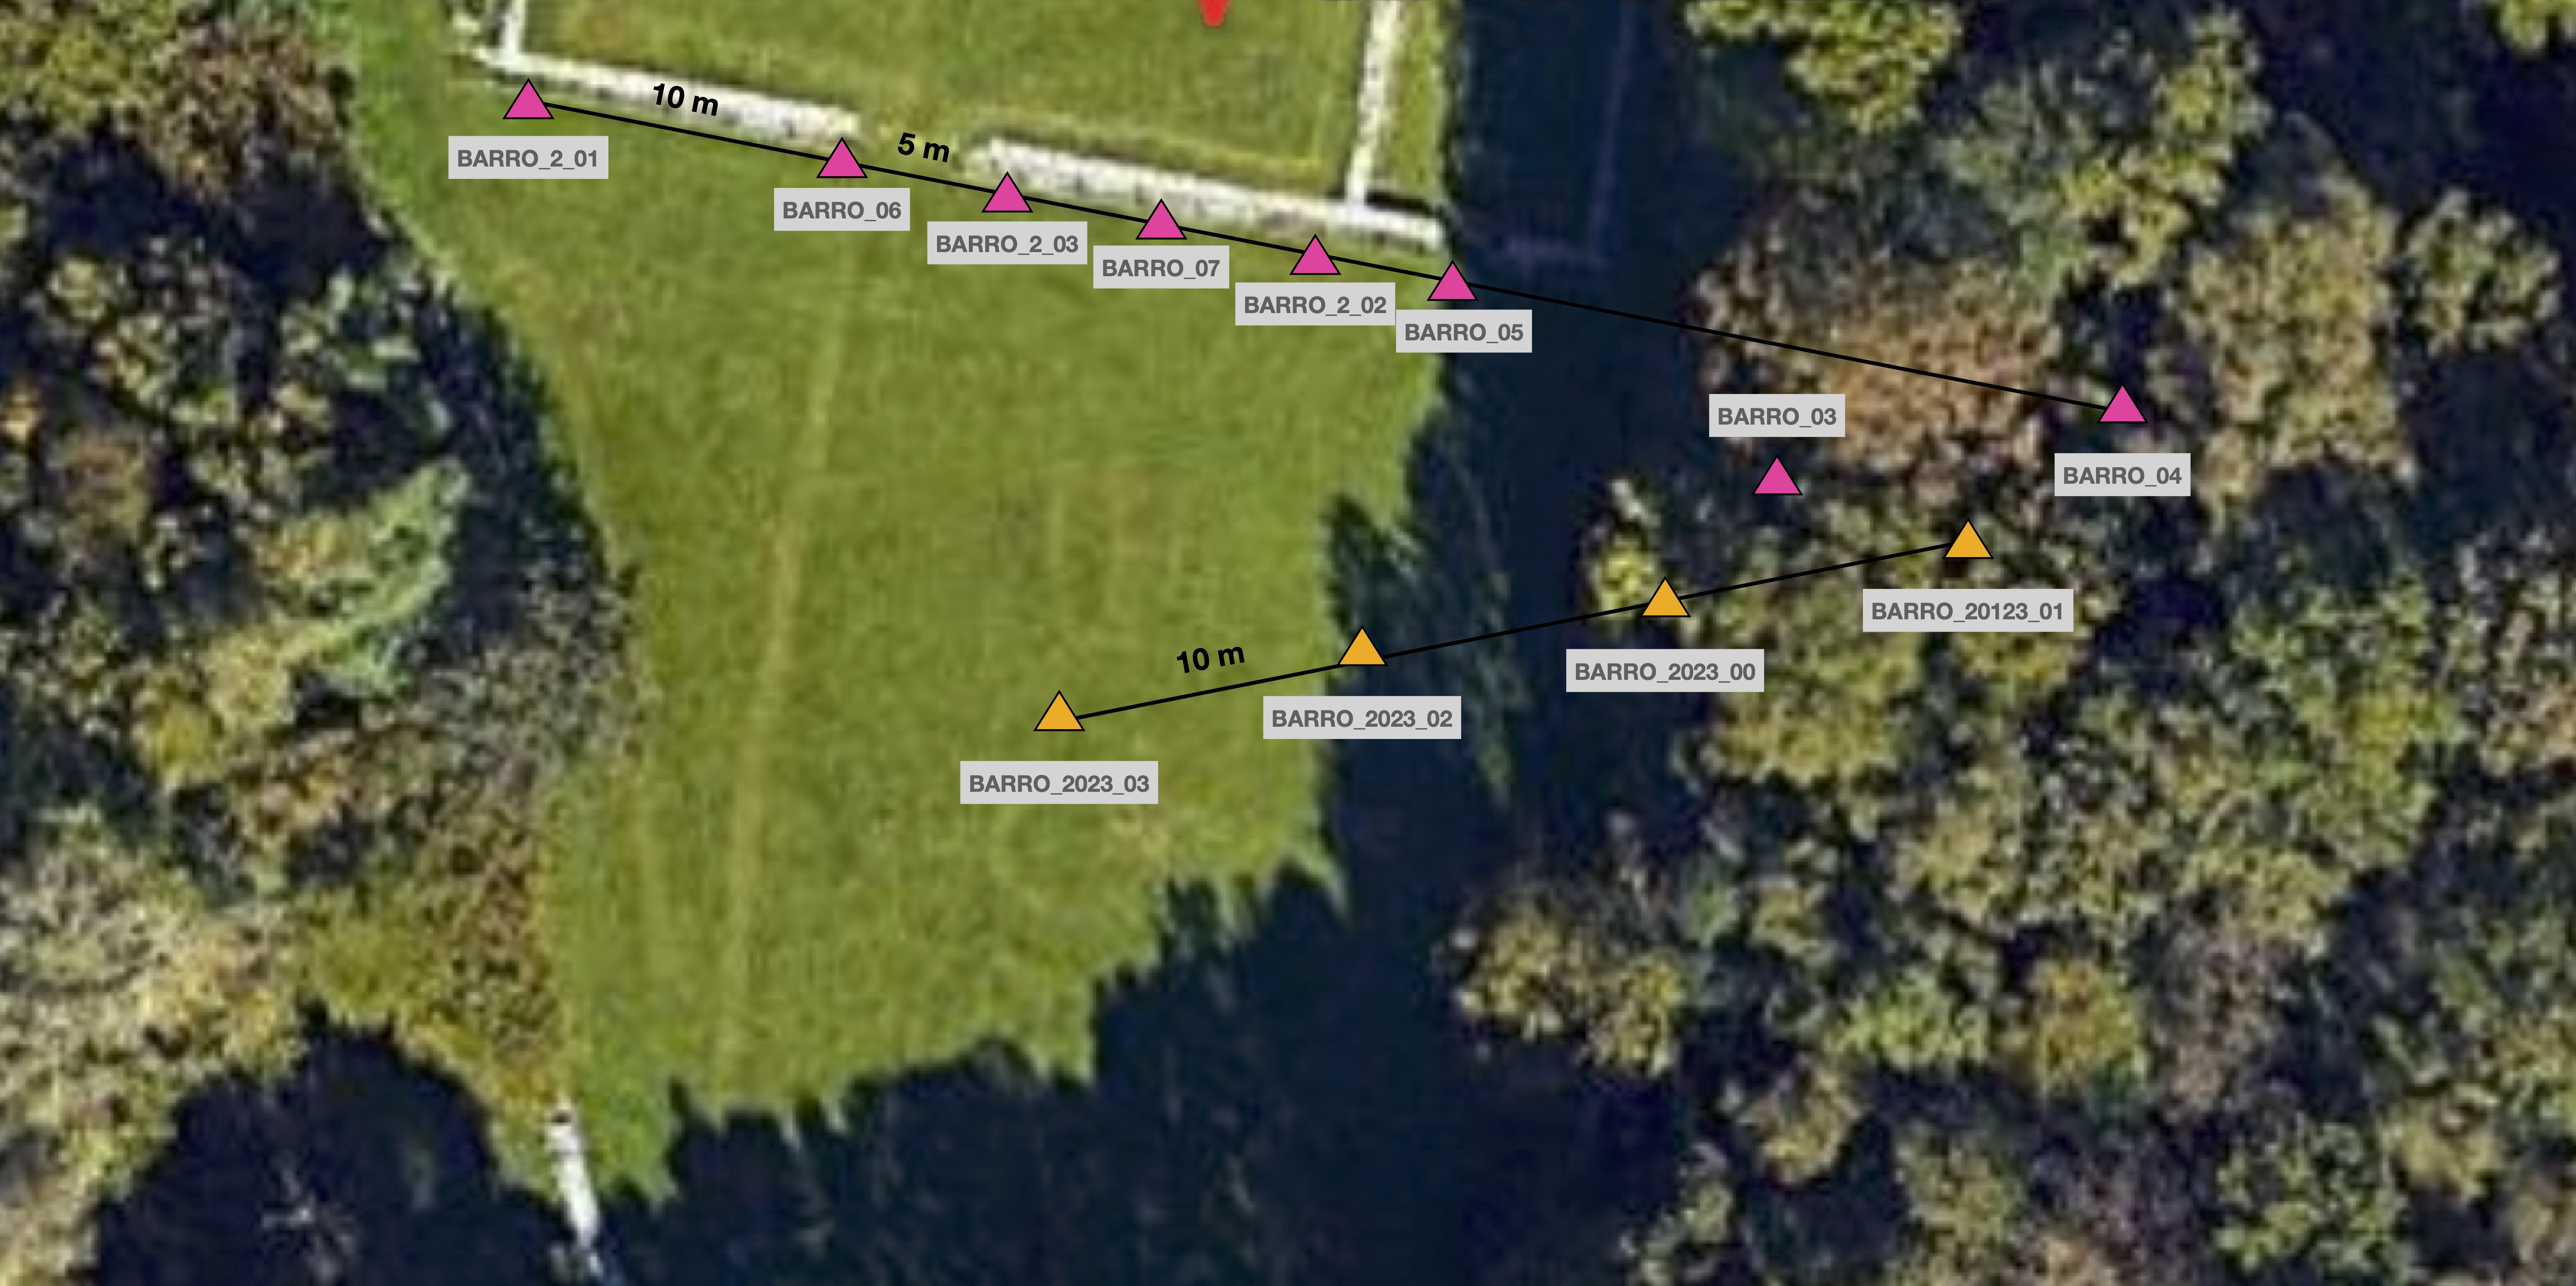

In [3]:
Image("img/monte_barro_stations_map_2023.jpeg",width=1000)

### Definizioni

In [4]:
# Variabili utilizzate nel Notebook per l'analisi
#
#PASI data
STAT_NAME="MONTE_BARRO_2023_03"                   # LABEL per i file creati
datafile='input/monte_barro_2023_p003.SAF'         # File che contine i dati
station_list='info/MONTE_BARRO.info'         # Information on PASI stations


# Input/output
OUTDIR='output/'                              # Directory for archiving output

# Parametri per PASI data
PASI_fs = 500                                 # PASI sampling rate

# WORKFLOW

### (0) Read the information about the seismic stations (locations) along the line, in case of multiple measurements

In case of multiple recordings in different sites, we need to define the geometry of acquisition. IN this simple case, the seismic stations have been installed along a line, equispaced by 10 meters. 

In [5]:
statfile = open(station_list, 'r')
STAT = []
stat_x = []
stat_topo = []


linestoken=statfile.readlines()
istat=0
n_pasi=0
for x in linestoken:

    if istat > 0: 
        n_pasi+=1
        STAT0=(x.split()[0])
        topo0=(x.split()[1])
        x0=(x.split()[2])
        STAT.append(STAT0)
        stat_x.append(x0)
        stat_topo.append(topo0)
        #print(STAT0,x0)

    istat += 1
    
print('Found', n_pasi, 'PASI stations ...')

Found 5 PASI stations ...


## (1) Read three component recordings of seismci noise

We now read the files downloaded from the GDrive. The data represent the three component ground-velocity along three orthogonal directions, acquired in the observation point. Data are organizes in three columns file, with one component in each column. First column is the vertical component.


In [6]:


pasifile = open(datafile, 'r')
V_data = []
N_data = []
E_data = []


ndata=0
linestoken=pasifile.readlines()
iline=0
for x in linestoken:
    iline+=1
    if iline > 42:
        ndata+=1  
        V0=float(x.split()[0])
        N0=float(x.split()[1])
        E0=float(x.split()[2])    
        V_data.append(V0)
        N_data.append(N0)
        E_data.append(E0)
        #print(ndata,V0,N0,E0)

print('Found', ndata, ' samples in file:', datafile)



Found 515038  samples in file: input/monte_barro_2023_p003.SAF


### (1.1) Visualize raw data

We now observe the origianl, raw data to see if we have transient seismci noise sources (i.e.  machinaries, a perosn walking close to the seismometers, pumps). All transient noise sources MUST be removed.

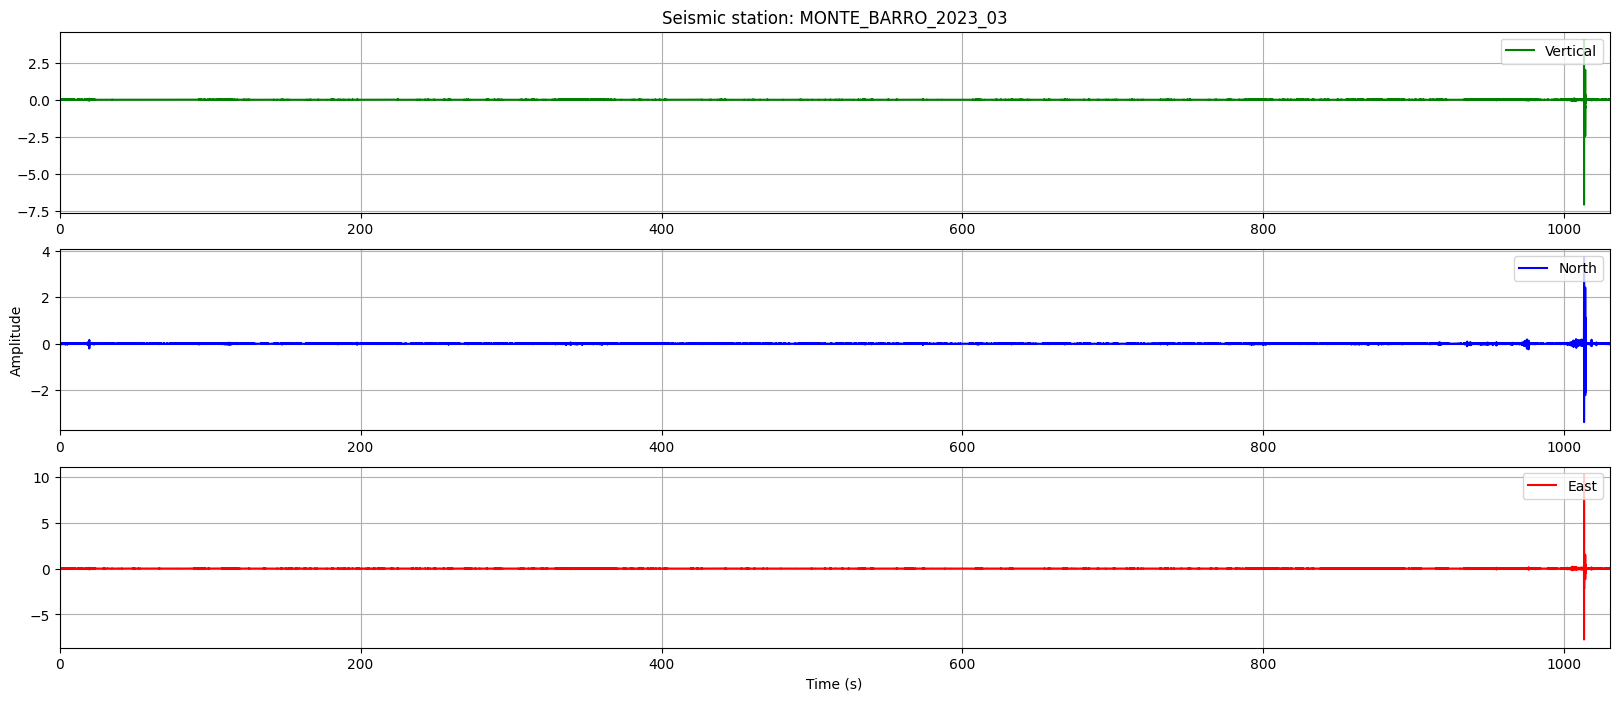

In [7]:
length_sec=ndata/PASI_fs

t = []
t=np.arange(0,length_sec,1.0/PASI_fs)

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20, 8))
ax1.set_title('Seismic station: ' + STAT_NAME)
ax1.set_xlim(0,length_sec)
ax1.grid()
ax1.plot(t,V_data, color='green', linestyle='-', label='Vertical')  
ax1.legend(loc='upper right')
ax2.set_xlim(0,length_sec)
ax2.grid()
ax2.plot(t,N_data, color='blue', linestyle='-', label='North')  
ax2.legend(loc='upper right')
ax2.set_ylabel('Amplitude')
ax3.set_xlim(0,length_sec)
ax3.grid()
ax3.plot(t,E_data, color='red', linestyle='-', label='East')  
ax3.legend(loc='upper right')
ax3.set_xlabel('Time (s)')
plt.show()
    
    

### (1.2) Visualize filtered data

We can now try to remove the transient noise sources filtering the data (as done for the DAS data).

#### Filtro Butterworth

In [10]:

#
# MIN and MAX FREQ are expressed in terms of Nyquist frequency (1/(2*sampling rate), 250Hz)
#
# (in our case, we set : MIN FREQUENCY (Wn[1]) is 0.004 => 250*0.004 = 1Hz))
# (in our case, we set : MAX FREQUENCY (Wn[2]) is 0.2 => 250*0.2 = 50Hz)
#
MIN_FREQ=0.004
MAX_FREQ=0.2
#
bandpass_filter = signal.butter(2,Wn=[MIN_FREQ,MAX_FREQ],btype='band',output='sos')
V_filt_data = signal.sosfilt(bandpass_filter, V_data)
N_filt_data = signal.sosfilt(bandpass_filter, N_data)
E_filt_data = signal.sosfilt(bandpass_filter, E_data)

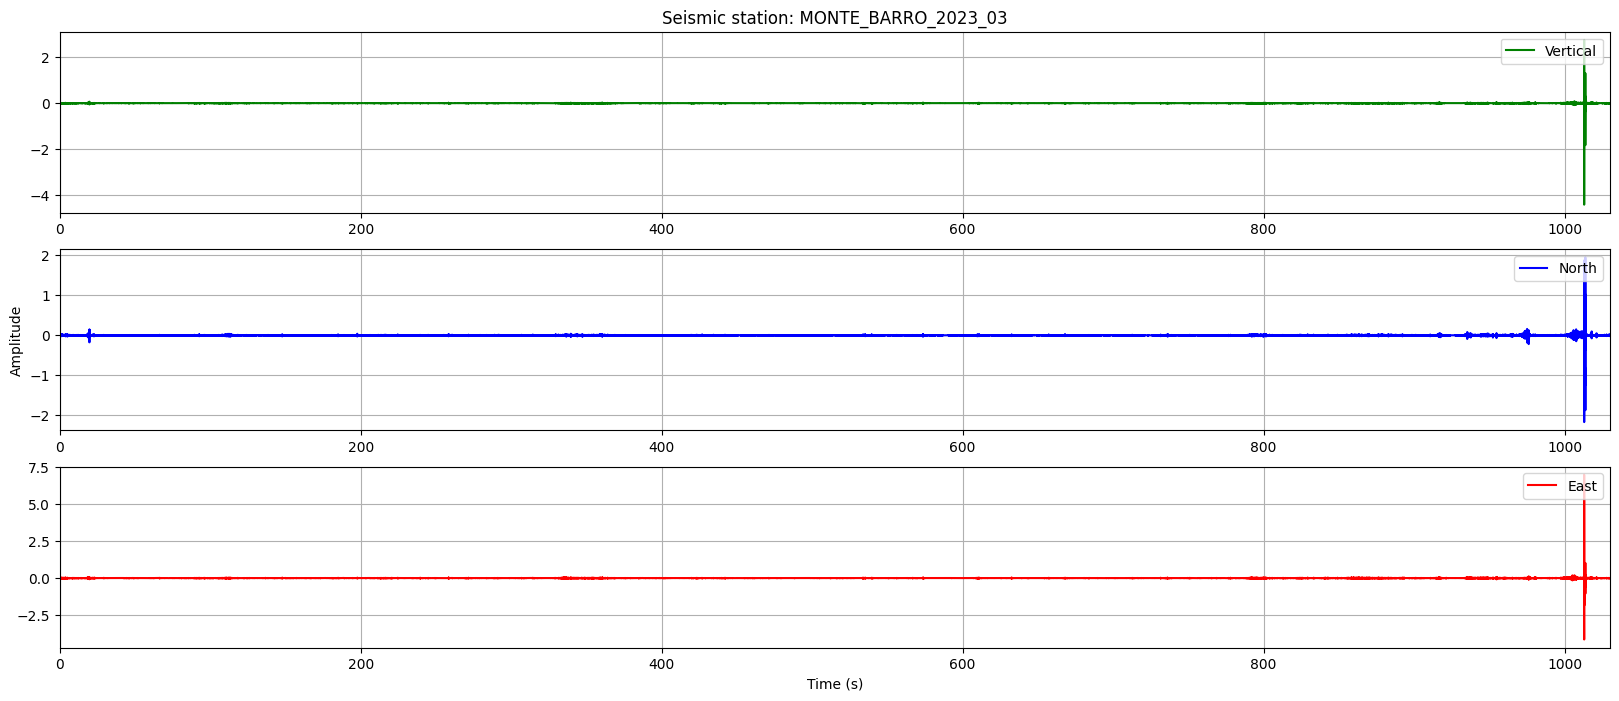

In [11]:

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20, 8))
ax1.set_title('Seismic station: ' + STAT_NAME)
ax1.set_xlim(0,length_sec)
ax1.grid()
ax1.plot(t,V_filt_data, color='green', linestyle='-', label='Vertical')  
ax1.legend(loc='upper right')
ax2.set_xlim(0,length_sec)
ax2.grid()
ax2.plot(t,N_filt_data, color='blue', linestyle='-', label='North')  
ax2.legend(loc='upper right')
ax2.set_ylabel('Amplitude')
ax3.set_xlim(0,length_sec)
ax3.grid()
ax3.plot(t,E_filt_data, color='red', linestyle='-', label='East')  
ax3.legend(loc='upper right')
ax3.set_xlabel('Time (s)')
plt.show()
    
    

## (2) Define transient anthropic noise on the vertical components

We now define a time-window where we have NO transient seismic noise sources. The next steps of the analysis will be done on such time-window only, where "natural" seismic ambient noise is present (homogeneous noise hypothesis).

In [12]:
file_path = './output/' + STAT_NAME + '.HVSR_window'
window_file=open(file_path,'w')

IN_COMP=input('Select one channel [V,N,E]: ')

if IN_COMP == "V":
    tr0 = V_data
if IN_COMP == "N":
    tr0 = N_data
if IN_COMP == "E":
    tr0 = E_data

    
@interact(START=widgets.FloatSlider(min=0.001, max=length_sec, step=0.001, value=10,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          END=widgets.FloatSlider(min=0.001, max=length_sec, step=0.001, value=20,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          X=widgets.FloatRangeSlider(value=[0.001, length_sec], min=0,max=length_sec, step=0.1, description='ZOOM',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_picking(START, END, X, Save):
    
    x_0=int(X[0])*(int(ndata/3600))
    x_1=int(X[1])*PASI_fs
    t_plot = []
    tr0_plot = []
    t_plot = t[x_0:x_1]
    tr0_plot=tr0[x_0:x_1]


    plt.figure(figsize=(18,3))
    plt.plot(t_plot,tr0_plot)
    plt.grid()
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    plt.title('Selected channel:' + IN_COMP)
    plt.xlim(X[0],X[1])
    plt.ylim(-0.1,0.1)
    plt.axvline(x=START, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    plt.axvline(x=END, ymin=0.10, ymax=0.90,linewidth=4, color='b')
    print('Seismic channel: ' + IN_COMP + '   Time-window for the HVSR analysis: ', START, END)
    if Save == True:
        START_HVSR=int(START*PASI_fs)
        END_HVSR=int(END*PASI_fs)
        print('\nSaving selected time-window for channel ' + IN_COMP + ' in samples:', START_HVSR,' -  ', END_HVSR )
        window_file.write('%20d%20d%12s\n' % (START_HVSR, END_HVSR,IN_COMP))
        window_file.flush()
    plt.figure()
    


Select one channel [V,N,E]: N


interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='START', layout=Layout(heig…

## (3) Select data inside a time-window without relevant anthropic noise

The code now selects the data for the analysis, from the time-window defined in the previous step

In [13]:
# Read results
resultfile = open(file_path, 'r')
linestoken=resultfile.readlines()
i=1
for x in linestoken:
    START_HVSR=int(x.split()[0])
    END_HVSR=int(x.split()[1])
    #print(START_HVSR, END_HVSR)

V_data_sele = []
N_data_sele = []
E_data_sele = []

i=0
ndata_sele=0

while i < ndata:
    
    if i >= START_HVSR and i <= END_HVSR:
        ndata_sele+=1
        V0=V_data[i]
        N0=N_data[i]
        E0=E_data[i]
        V_data_sele.append(V0)
        N_data_sele.append(N0)
        E_data_sele.append(E0)
        
    i+=1

print('\n Found ', ndata_sele, ' samples in the selected time-window')


 Found  379395  samples in the selected time-window


## (4) Compute spectral content using a Fast Fourier Transform for each component

The frequency spectrum of each component is computed using a Fourier transform routine. Being the signal evenly-spaced, we can use the discrete Fourier Transfrom (and thus the Fast Fourier Transform).

(see  Stefan Wörner doc in the folder on e-learning)

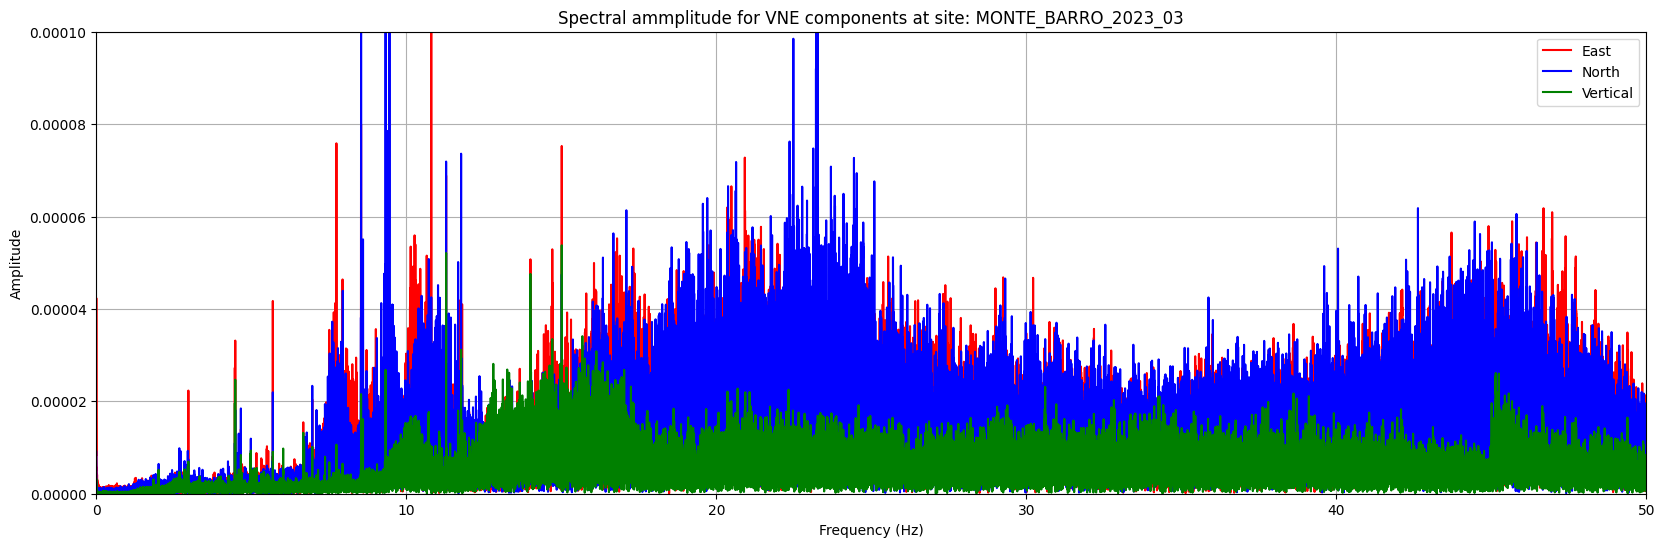

In [14]:
# Number of sample points
N = ndata_sele

# sample spacing
T = 1.0 / PASI_fs

x = np.linspace(0.0, N*T, N, endpoint=False)

V0 = V_data_sele
N0 = N_data_sele
E0 = E_data_sele

V_yf = fft(V0)
N_yf = fft(N0)
E_yf = fft(E0)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(20, 6))
plt.plot(xf, 2.0/N * np.abs(E_yf[0:N//2]), color='red', label='East')
plt.plot(xf, 2.0/N * np.abs(N_yf[0:N//2]), color='blue', label='North')
plt.plot(xf, 2.0/N * np.abs(V_yf[0:N//2]), color='green', label='Vertical')
plt.xlim(0,50)
plt.legend(loc='upper right')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.title('Spectral ammplitude for VNE components at site: '+ STAT_NAME )
plt.ylim(0,0.0001)
plt.grid()
plt.show()

## (5) Compute the H/V spectral ratio

From the spectr of the three components, we can compute the H/V spectral ratio at different frequency Following the approach in Liang et al. (2018), we only compute only HVSR from the combination of the two horizontal components:

$$ HVSR(f) = \sqrt{ \frac{N(f) \times E(f) }{ V(f)^2 } } $$

where $HVSR(f)$ is our target function $f$, $V(f),N(f),E(f)$ are the amplitude of the spectra of the three components at frequency $f$. 

Due to the nature of the analysed signal, (a discrete signal and not coninuous function) the spectra can have " hole" where the amplitude of the spectra is very small. In such cases, the HVSR can have atefacts, very high peaks that bias the results. To avoid such issue, we smooth the HVSR to make it more stable, with a average over a moving window (so called "smoothing filter").

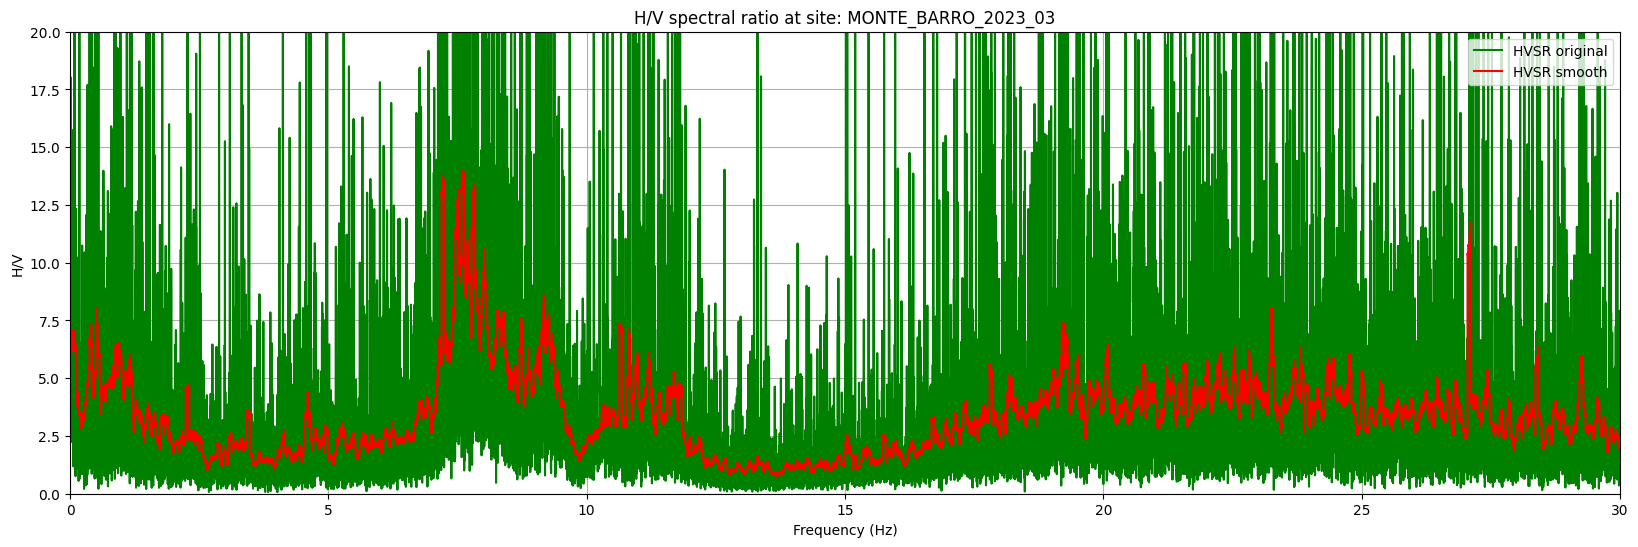

In [15]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

HVSR = []

E_amp = 2.0/N * np.abs(E_yf[0:N//2])
N_amp = 2.0/N * np.abs(N_yf[0:N//2])
V_amp = 2.0/N * np.abs(V_yf[0:N//2])


# Calcolo rapporto spettrale H/V
i=0
while i < N//2:
    HVSR0= sqrt ( (E_amp[i] * N_amp[i])/(V_amp[i]*V_amp[i]) )
    HVSR.append(HVSR0)
    i += 1
    
# Appliczione media mobile
HVSR_smooth = smooth(HVSR, 51) 

                       
plt.figure(figsize=(20, 6))
plt.plot(xf, HVSR, color='green', label='HVSR original')
plt.plot(xf, HVSR_smooth, color='red', label='HVSR smooth')
plt.xlim(0,30)
plt.legend(loc='upper right')
plt.ylabel('H/V')
plt.xlabel('Frequency (Hz)')
plt.title('H/V spectral ratio at site: '+ STAT_NAME )
plt.ylim(0,20)
plt.grid()
plt.show()                     

## (6) Define the sedimentary layer thickness, in a single layer model, form the maximum value of the HVSR graph (using a predefined S-wave velocity)


We now use the formula:

$$ Z= \frac{ \bar{V_S} }{4 \times f_{MAX} } $$

whre $Z$ is the depth of the bottom of the low S-wave velocity layer, $\bar{V_S}$ is the mean S-wave velocity in such layer, and $f_{MAX}$ is the frequency of the maximum of the HVSR function.


In [17]:
file_path = './output/MONTE_BARRO.results'

if os.path.exists(file_path):
    print('File: ', file_path, 'exists. New data will be appended')
    results_file=open(file_path,'a')
else:
    results_file=open(file_path,'w')
    results_file.write('%20s\n' % ('#MAX_FREQ         Vs or (a,b)          Z        STAT'))
    
@interact(Vs=widgets.FloatSlider(min=100.0, max=200.0, step=0.1, value=150.0,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          MAX=widgets.FloatSlider(min=0.001, max=50, step=0.1, value=20,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_hvsr_Vs(Vs, MAX, Save):
    
    Z= Vs/(4.0*MAX)
    plt.figure(figsize=(18,3))
    plt.plot(xf, HVSR_smooth, color='blue', label='V smooth')
    plt.grid()
    plt.ylabel('H/V')
    plt.xlabel('Frequency (Hz)')
    plt.title('Maximum HVSR for station:' + STAT_NAME )
    plt.xlim(0,50)
    plt.axvline(x=MAX, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    print('Seismic station: ' + STAT_NAME + ' -  MAX for HVSR: ', MAX ,'which correspond to a depth of: ', Z)
    if Save == True:
        print('\nSaving maximum of HVSR for station: ' + STAT_NAME + ' at freq: ', MAX )
        results_file.write('%8.1f%14s%6.2f%14.1f%20s\n' % (MAX, '  -  ', Vs, Z ,STAT_NAME))
        results_file.flush()
    plt.figure()


File:  ./output/MONTE_BARRO.results exists. New data will be appended


interactive(children=(FloatSlider(value=150.0, continuous_update=False, description='Vs', layout=Layout(height…

## (7) Define the sedimentary layer thickness, in a single layer model, form the maximum value of the HVSR graph (using a parameter fitting on a,b )


We now use the formula:

$$ Z= a \times ({f}_{MAX})ˆb $$

dove $Z$ is the depth of the bottom of the low S-wave velocity layer, $(a,b)$ are the couple of parameters that need to be estimated (usually with data from near-by boreholes), and $f_{MAX}$ is the frequency of the maximum of the HVSR function.

In [18]:
    
@interact(a=widgets.FloatSlider(min=55.0, max=110.0, step=0.1, value=60.0,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          b=widgets.FloatSlider(min=-1.4, max=-1.0, step=0.01, value=-1.02,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          MAX=widgets.FloatSlider(min=0.001, max=50, step=0.1, value=20,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_hvsr_Vs(a, b, MAX, Save):
    
    Z= a * pow(MAX,b)
    plt.figure(figsize=(18,3))
    plt.plot(xf, HVSR_smooth, color='blue', label='V smooth')
    plt.grid()
    plt.ylabel('H/V')
    plt.xlabel('Frequency (Hz)')
    plt.title('Maximum HVSR for station:' + STAT_NAME )
    plt.xlim(0,50)
    plt.axvline(x=MAX, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    print('Seismic station: ' + STAT_NAME + ' -  MAX for HVSR: ', MAX ,'which correspond to a depth of: ', Z)
    if Save == True:
        print('\nSaving maximum of HVSR for station: ' + STAT_NAME + ' at freq: ', MAX )
        results_file.write('%8.1f%14.1f%6.2f%14.1f%20s\n' % (MAX, a,b, Z ,STAT_NAME))
        results_file.flush()
    plt.figure()


interactive(children=(FloatSlider(value=60.0, continuous_update=False, description='a', layout=Layout(height='…

In [ ]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,ipywidgets,scipy